In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle
import os

# matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

In [6]:
df = pd.read_csv('F:\MLP\music-genre-classification-master\music-genre-classification-master\df_features.csv')
print(df.shape)
df.head()

(25221, 98)


,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_3_std,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std
0,15987_Rock_music.wav,0.123,0.160,0.745,-0.176,0.112,0.095,0.150,0.056,135.999,...,0.259,0.250,0.338,0.209,0.321,0.264,0.261,0.238,0.318,0.290
1,11384_Pop_music.wav,0.157,0.204,1.171,0.413,0.092,0.069,0.195,0.058,103.359,...,0.250,0.243,0.256,0.324,0.232,0.345,0.306,0.378,0.272,0.261
2,14963_Rock_music.wav,0.122,0.187,1.781,2.852,0.059,0.048,0.149,0.113,135.999,...,0.271,0.198,0.334,0.235,0.327,0.405,0.304,0.291,0.172,0.305
3,16792_Rock_music.wav,0.267,0.333,0.814,-0.279,0.117,0.039,0.328,0.053,117.454,...,0.366,0.201,0.244,0.350,0.270,0.358,0.275,0.307,0.256,0.224
4,15329_Pop_music.wav,0.180,0.229,1.179,0.358,0.170,0.030,0.225,0.041,135.999,...,0.258,0.269,0.260,0.243,0.243,0.266,0.284,0.282,0.200,0.225


In [7]:
label_dict = {'Hip':0,
              'Pop':1,
              'Vocal':2,
              'Rhythm':3,
              'Reggae':4,
              'Rock':5,
              'Techno':6,
             }

# Normalization of the features
scalar = MinMaxScaler()
df[df.columns[1:]] = scalar.fit_transform(df[df.columns[1:]])
df['label'] = df['file_name'].apply(lambda x: label_dict[x[:-4].split('_')[1]])
df.head()

,file_name,signal_mean,signal_std,signal_skew,signal_kurtosis,zcr_mean,zcr_std,rmse_mean,rmse_std,tempo,...,chroma_stft_4_std,chroma_stft_5_std,chroma_stft_6_std,chroma_stft_7_std,chroma_stft_8_std,chroma_stft_9_std,chroma_stft_10_std,chroma_stft_11_std,chroma_stft_12_std,label
0,15987_Rock_music.wav,0.130297,0.167539,0.160626,0.001601,0.183007,0.358491,0.157398,0.176101,0.363525,...,0.518908,0.723176,0.441964,0.691111,0.546584,0.540094,0.488017,0.700450,0.622912,5
1,11384_Pop_music.wav,0.166314,0.213613,0.174350,0.002131,0.150327,0.260377,0.204617,0.182390,0.226045,...,0.504202,0.547210,0.698661,0.493333,0.714286,0.646226,0.793028,0.596847,0.553699,1
2,14963_Rock_music.wav,0.129237,0.195812,0.194001,0.004325,0.096405,0.181132,0.156348,0.355346,0.363525,...,0.409664,0.714592,0.500000,0.704444,0.838509,0.641509,0.603486,0.371622,0.658711,5
3,16792_Rock_music.wav,0.282839,0.348691,0.162849,0.001509,0.191176,0.147170,0.344176,0.166667,0.285413,...,0.415966,0.521459,0.756696,0.577778,0.741201,0.573113,0.638344,0.560811,0.465394,5
4,15329_Pop_music.wav,0.190678,0.239791,0.174608,0.002082,0.277778,0.113208,0.236097,0.128931,0.363525,...,0.558824,0.555794,0.517857,0.517778,0.550725,0.594340,0.583878,0.434685,0.467780,1


In [133]:
print(df[df.file_name=='15329_Pop_music.wav'].index[0])

4


In [8]:
# Train-test split of files # Same split as used for VGG model
with open(os.path.join('F:\MLP\music-genre-classification-master\music-genre-classification-master\pred_probas','testset_filenames.txt'), 'r') as f:
    test_files = f.readlines()
test_files = [t.strip() for t in test_files]

indices = []
for t in test_files:
    indices.append(df[df.file_name==t].index[0])

print(indices)
    
df_test = df.iloc[indices,:]
df.drop(labels=indices, inplace=True)

cl_weight = dict(pd.Series(df['label']).value_counts(normalize=True))

x_train = df[df.columns[1:-1]]
x_test = df_test[df.columns[1:-1]]
y_train = df['label']
y_test = df_test['label']

[7640, 14332, 16266, 23318, 24983, 21527, 25155, 21721, 17677, 15464, 22920, 16402, 13212, 5896, 18679, 5308, 25147, 13339, 12998, 5773, 934, 9556, 23091, 23887, 11664, 14494, 19019, 13093, 24112, 12893, 16919, 21361, 16877, 7228, 24524, 14954, 6235, 19575, 3133, 22269, 12531, 21362, 19851, 19734, 1979, 5293, 15235, 8717, 15834, 13950, 7315, 4728, 20750, 21170, 3895, 22226, 12358, 2227, 8507, 18101, 4855, 18026, 11640, 9596, 17093, 20440, 14089, 12353, 5449, 5193, 3923, 5901, 14949, 13690, 18788, 22104, 4754, 18167, 4415, 18270, 12579, 16171, 3242, 6945, 14886, 18076, 13597, 7515, 23446, 15542, 2962, 12894, 6182, 96, 3941, 2535, 19704, 16076, 14316, 22455, 5889, 23096, 9245, 2240, 19810, 18477, 2752, 14540, 21582, 24976, 22866, 3256, 5072, 20510, 14328, 15801, 3885, 18892, 3104, 4910, 9974, 23499, 22403, 4150, 9060, 3717, 23637, 12299, 3075, 24880, 15954, 3270, 6659, 24910, 12606, 19282, 17856, 6079, 12233, 1448, 20795, 4387, 3266, 15843, 953, 17946, 16061, 828, 21549, 580, 21807, 1061

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(label_dict))
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=label_dict.keys())

In [24]:
df.signal_skew

0        0.160626
1        0.174350
2        0.194001
3        0.162849
4        0.174608
           ...   
25221    0.188589
25223    0.166264
25225    0.198447
25226    0.174221
25227    0.160691
Name: signal_skew, Length: 23966, dtype: float64

In [10]:
x=[]
for c in df.columns:
    x.append(df[c].isnull().sum())
    if df[c].isnull().values.any()==True:
        print(c)
        for i in df[c]:
            if i=='':
                print(i)
    

print(x)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [11]:

df.isnull().sum().sum()

0

### Logistic Regression
LR is usually done for binary classification tasks. For this multi-class classification task, the LR is implemented as a one-vs-rest method. That is, 7 separate classifiers are trained. During test time, the class with the highest prob. from among the 7 classifiers is the predicted class.

c:\Users\Vishnuvardhan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Set Accuracy =  0.49
Test Set F-score =  0.44
ROC AUC = 0.809
Confusion matrix, without normalization
[[ 85  16   0   6   5   9  30]
 [ 29  52   5  13   1  33  21]
 [  4  11  36   2   0  11   4]
 [ 17  27   7  18   4  17  16]
 [ 22  14   1   8  12   3   6]
 [  6  16   2   4   0 152  34]
 [ 29  26   6   8   0  32 140]]
Wall time: 4.02 s


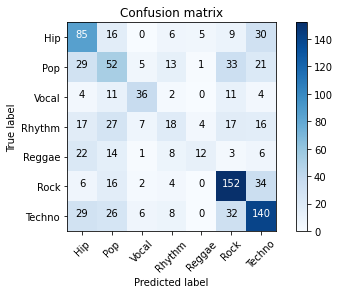

In [12]:
%%time
# Train
lr_classifier = LogisticRegression(penalty='l2')
lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('F:\MLP\music-genre-classification-master\music-genre-classification-master\pred_probas\lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Random Forest

Test Set Accuracy =  0.51
Test Set F-score =  0.44
ROC AUC = 0.829
Confusion matrix, without normalization
[[ 83  20   1   5   4   3  35]
 [ 33  58   5  12   0  31  15]
 [  7   9  39   1   0   9   3]
 [ 24  22   7  21   0  15  17]
 [ 31   9   1  12   5   3   5]
 [  5  18   5   3   0 154  29]
 [ 20  27   8   6   0  31 149]]
Wall time: 1min 35s


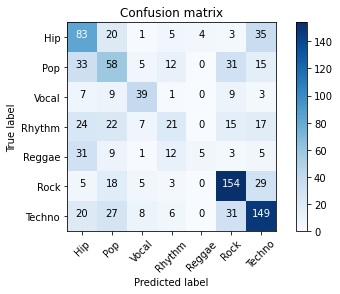

In [14]:
%%time
# Train
rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=5)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open(os.path.join('F:\MLP\music-genre-classification-master\music-genre-classification-master\pred_probas','rf_classifier.pkl'), 'wb') as f:
    pickle.dump(pred_probs, f)

### Gradient Boosting 

[15:47:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sub_sample" } are not used.

Test Set Accuracy =  0.53
Test Set F-score =  0.48
ROC AUC = 0.850
Confusion matrix, without normalization
[[ 87  20   0   9   7   6  22]
 [ 29  60   3  16   3  25  18]
 [  1  12  34   4   0  10   7]
 [ 17  24   6  25   6  14  14]
 [ 20  12   2  11  18   1   2]
 [  6  32   2   9   0 142  23]
 [ 18  21   7   7   0  29 159]]
Wall time: 4min 16s


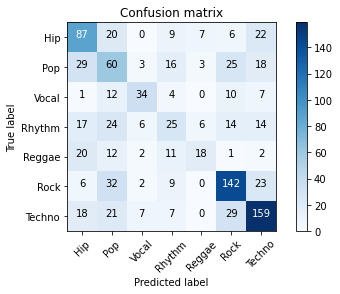

In [26]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open(os.path.join('F:\MLP\music-genre-classification-master\music-genre-classification-master\pred_probas','xgb_classifier.pkl'), 'wb') as f:
    pickle.dump(pred_probs, f)

### Support Vector Machines

Test Set Accuracy =  0.50
Test Set F-score =  0.43
ROC AUC = 0.808
Confusion matrix, without normalization
[[ 79  29   2   4   3   7  27]
 [ 27  74   5   3   0  22  23]
 [  7   8  29   3   1  13   7]
 [ 22  28   6  11   2  16  21]
 [ 27  14   2   8  12   2   1]
 [  4  27   4   7   1 138  33]
 [ 17  30   9   3   2  25 155]]
Wall time: 19min 54s


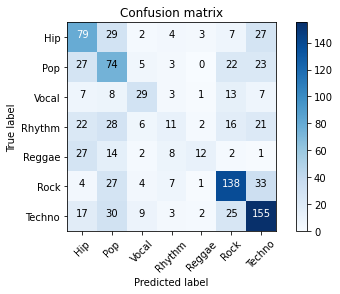

In [16]:
%%time
# Train
svm_classifier = SVC(C=10000.0, probability = True, class_weight=cl_weight, kernel='rbf')
svm_classifier.fit(x_train, y_train)

# Predict
pred_probs = svm_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

# Save
with open('F:\MLP\music-genre-classification-master\music-genre-classification-master\pred_probas\svm_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Most Important Feature
Determine the features that contribute the most towards making the correct classfication

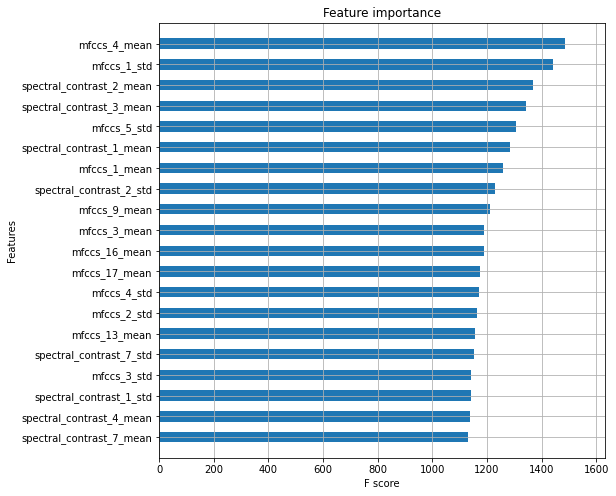

In [17]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=20, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)
# plt.savefig('plots/feature-imp.png', bbox_inches='tight')

The most important features seem to be MFCCs and spectral contrast (mean and std dev in different frequency bins). Use the top N features, build the model and look at the metrics

In [18]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.00726332, 0.00731464, 0.0092537 , 0.01034158, 0.01201099,
       0.007161  , 0.00708896, 0.00972653, 0.02154547, 0.00993087,
       0.01986198, 0.01026508, 0.00874467, 0.01126846, 0.01169711,
       0.        , 0.        , 0.00996659, 0.01459021, 0.02878835,
       0.00995288, 0.00870008, 0.01796741, 0.00914651, 0.00738125,
       0.00958535, 0.0083998 , 0.0067192 , 0.00963566, 0.008171  ,
       0.00711544, 0.01124987, 0.00846975, 0.01036165, 0.01069026,
       0.01322807, 0.01512943, 0.0086201 , 0.01660179, 0.00889292,
       0.01569339, 0.01932441, 0.00905117, 0.00981873, 0.01191229,
       0.01128861, 0.01110074, 0.0096451 , 0.00937289, 0.01491229,
       0.01012077, 0.00670874, 0.00813001, 0.01309033, 0.01277003,
       0.01206218, 0.01483656, 0.03265047, 0.01542925, 0.0152521 ,
       0.00937773, 0.01054824, 0.01296894, 0.0232571 , 0.00753961,
       0.00774831, 0.00712541, 0.00779732, 0.00784909, 0.01564544,
       0.00813238, 0.00828717, 0.01212623, 0.01357259, 0.00652

In [19]:
top_n = [10, 20, 30]
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                       n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm = False)     
    print()

Stats for top 10 features:
[15:38:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sub_sample" } are not used.



c:\Users\Vishnuvardhan\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\Vishnuvardhan\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Test Set Accuracy =  0.46
Test Set F-score =  0.41
ROC AUC = 0.791

Stats for top 20 features:
[15:39:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sub_sample" } are not used.



c:\Users\Vishnuvardhan\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\Vishnuvardhan\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Test Set Accuracy =  0.50
Test Set F-score =  0.44
ROC AUC = 0.821

Stats for top 30 features:
[15:40:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sub_sample" } are not used.



c:\Users\Vishnuvardhan\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\Vishnuvardhan\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Test Set Accuracy =  0.51
Test Set F-score =  0.47
ROC AUC = 0.828



### Ensemble of XGB and VGG

Test Set Accuracy =  0.61
Test Set F-score =  0.56
ROC AUC = 0.874
Confusion matrix, without normalization
[[ 83  12   0  13  13   5  23]
 [ 17  63   3  19   4  32  16]
 [  0   8  47   2   0   5   5]
 [ 12  18   4  30   8  15  18]
 [ 11   7   2  12  26   3   3]
 [  3  15   6   8   2 161  18]
 [  4   9   7   5   0  22 193]]


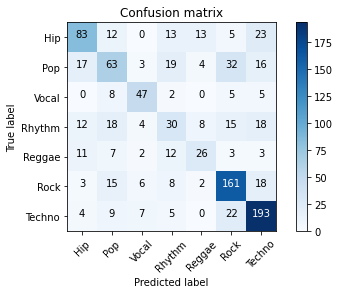

In [20]:
# Load predicted probabilities
with open('pred_probas/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/vgg_fine_tuning.pkl', 'rb') as f:
    vgg_pred_probs = pickle.load(f)
    
n_samples = np.min([len(xgb_pred_probs), len(vgg_pred_probs)])

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs[:n_samples] + vgg_pred_probs[:n_samples])/2.0

# Show metrics
display_results(y_test[:n_samples], ensemble_pred_probs)

### Plot 3 ROCs the same graph
- VGG
- XGB
- Ensemble

In [21]:
# Compute macro-average ROC curve and ROC area
# Compute ROC curve and ROC area for each class

def plot_roc_curves(y_true, pred_probs, label_dict):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    NUM_CLASSES = len(label_dict)
    one_hot_true = one_hot_encoder(y_true, len(y_true), NUM_CLASSES)
    for i in range(len(label_dict)):
        fpr[i], tpr[i], _ = roc_curve(one_hot_true[:, i], pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])    

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= NUM_CLASSES

    return all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

C:\Users\Vishnuvardhan\AppData\Local\Temp\ipykernel_17552\2429327162.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])
C:\Users\Vishnuvardhan\AppData\Local\Temp\ipykernel_17552\2429327162.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])
C:\Users\Vishnuvardhan\AppData\Local\Temp\ipykernel_17552\2429327162.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


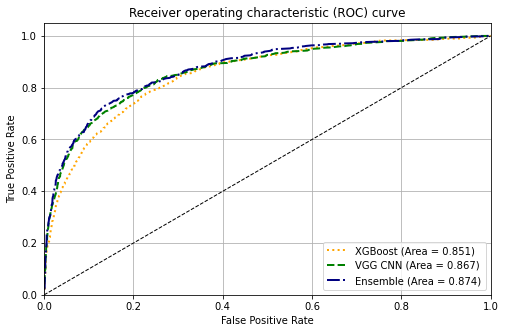

In [22]:
# Plot all ROC curves
plt.figure(figsize=(8,5))

plt.title('Macro-average ROC curves')

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], xgb_pred_probs[:n_samples], label_dict)
plt.plot(fpr, tpr,
         label='XGBoost (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='orange', linestyle=':', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], vgg_pred_probs[:n_samples], label_dict)
plt.plot(fpr, tpr,
         label='VGG CNN (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='green', linestyle='--', linewidth=2)

fpr, tpr, roc_auc = plot_roc_curves(y_test[:n_samples], ensemble_pred_probs[:n_samples]
                                    , label_dict)
plt.plot(fpr, tpr,
         label='Ensemble (Area = {0:0.3f})'
               ''.format(roc_auc),
         color='navy', linestyle='-.', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
# plt.savefig('plots/roc-curve.png')
plt.show()

#### Time Domain Feature Only

[15:53:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sub_sample" } are not used.

Test Set Accuracy =  0.38
Test Set F-score =  0.32
ROC AUC = 0.731
Confusion matrix, without normalization
[[ 63  22   0   7   8  11  40]
 [ 28  41   7  11   2  37  28]
 [  4  10  18   3   1  10  22]
 [ 23  20   6  18   6  13  20]
 [ 21  17   1   7   4   3  13]
 [ 12  32   5   7   2 117  39]
 [ 28  26   9   7   2  51 118]]
Wall time: 21.2 s


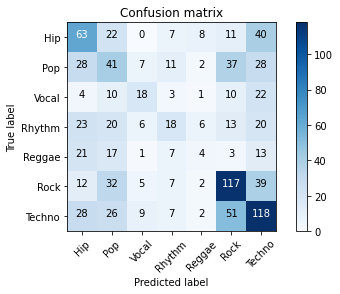

In [29]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train.iloc[:,:9], y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test.iloc[:,:9])

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier_time_domain.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

#### Frequency Domain Feature Only

[15:54:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sub_sample" } are not used.

Test Set Accuracy =  0.53
Test Set F-score =  0.49
ROC AUC = 0.839
Confusion matrix, without normalization
[[ 88  17   0   8   6   7  25]
 [ 36  59   3  13   3  25  15]
 [  4   8  38   4   0  10   4]
 [ 21  23   4  24   5  10  19]
 [ 20   8   1  14  17   3   3]
 [  4  27   1   9   1 149  23]
 [ 17  21   8  10   2  25 158]]
Wall time: 4min 15s


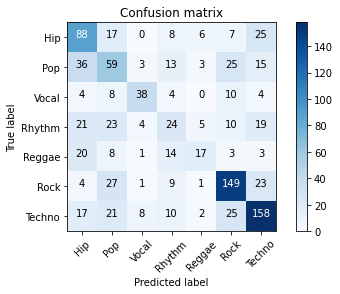

In [31]:
%%time
# Train
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, sub_sample = 0.8, num_class = len(label_dict))
xgb_classifier.fit(x_train.iloc[:,9:], y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test.iloc[:,9:])

# Results
display_results(y_test, pred_probs)

# Save
with open('pred_probas/xgb_classifier_freq_domain.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)